# COVID-19 Percent Positive in Italy

> Max Pierini, Sandra Mazzoli, Alessio Pamovio

Percent positive (**PP**), aka _Percent Positive Rate_ or _Positivity Rate_, can be considered as an index of disease transmission (ref: [Johns Hopkins](https://www.jhsph.edu/covid-19/articles/covid-19-testing-understanding-the-percent-positive.html)).

The index is calculated as

$$
\mathbf{PP} = \frac{ \Delta_\textrm{positive} }{ \Delta_\textrm{tested} }
$$

where $\Delta_\textrm{positive}$ is daily new amount of positive tests and $\Delta_\textrm{tested}$ is daily new amount of total tests.

When it's too high means that more tests are needed and/or pharmaceutical (PI) or non-pharmaceutical (NPI) interventions should be seriously considered to reduce transmission.

The "alarm threshold" has been established at 5%. World Health Organization recommend to relax COVID-19 NPI (lockdown and high level social distancing rules) if **PP** keeps below the threshold for at least two weeks.

We can add an "alert" threshold, between 3% and 5%: if **PP** raises over 3%, governments should consider a likely forthcoming alarm scenario. Below 3% can be considered in a safe area.

Percent positive index for Italy and italian regions is here calculated using Dipartimento di Protezione Civile published data (ref: [GitHub](https://github.com/pcm-dpc/COVID-19)) filtered with _Hampel filter_ (gaussian window of 7 days, $\sigma=2$) for regions with more than 30 new daily cases and smoothed with rolling mean (gaussian window of 14 days, $\sigma=5$).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, Markdown

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'nuovi_positivi', 'casi_testati'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

ko = df[df['casi_testati']>0]
countries = ko.index.get_level_values("denominazione_regione").unique().sort_values()
days = ko.index.get_level_values("data").unique()

In [3]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

# Index

- [Italy](#Italy)

In [4]:
index = "\n".join( f"- [{region}](#{region.replace(' ', '-')})" for region in countries )
display(Markdown(index))

- [Abruzzo](#Abruzzo)
- [Basilicata](#Basilicata)
- [Calabria](#Calabria)
- [Campania](#Campania)
- [Emilia-Romagna](#Emilia-Romagna)
- [Friuli Venezia Giulia](#Friuli-Venezia-Giulia)
- [Lazio](#Lazio)
- [Liguria](#Liguria)
- [Lombardia](#Lombardia)
- [Marche](#Marche)
- [Molise](#Molise)
- [P.A. Bolzano](#P.A.-Bolzano)
- [P.A. Trento](#P.A.-Trento)
- [Piemonte](#Piemonte)
- [Puglia](#Puglia)
- [Sardegna](#Sardegna)
- [Sicilia](#Sicilia)
- [Toscana](#Toscana)
- [Umbria](#Umbria)
- [Valle d'Aosta](#Valle-d'Aosta)
- [Veneto](#Veneto)

- [SUMMARY](#SUMMARY)

***

# Italy

In [5]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi', 'totale_casi', 'casi_testati', 'tamponi'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()

In [6]:
ok_it = it[it['casi_testati']>0]

## Plot

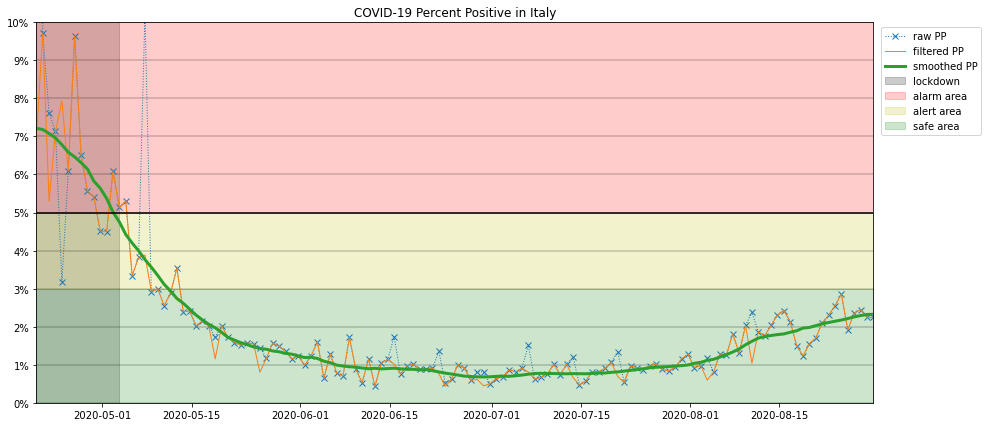

In [7]:
pos_it, pos_it_outs = hampel_filter_pandas(ok_it['nuovi_positivi'][1:], 7, n_sigmas=2.0)
pos_sm = pos_it.rolling(14,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=5).values

tst_it, tst_it_outs = hampel_filter_pandas(ok_it['casi_testati'].diff()[1:], 7, n_sigmas=2.0)
tst_sm = tst_it.rolling(14,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=5).values

tst_it[tst_it==0] = np.nan

indice = ok_it['nuovi_positivi'][1:] / ok_it['casi_testati'].diff()[1:] * 100
filtered = pos_it / tst_it * 100
smooth = pos_sm / tst_sm *100

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(indice, 'x:', label="raw PP", lw=1)
ax.plot(filtered, label="filtered PP", lw=1)
ax.plot(indice.index, smooth, lw=3, label="smoothed PP")

ax.hlines(np.arange(0,15,1), indice.index[0], indice.index[-1], color="k", alpha=.2)

ax.axhline(5, c="k")

ax.fill_betweenx(
    [0,20],
    indice.index[indice.index>=pd.to_datetime("2020-03-11")][0],
    indice.index[indice.index<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)

ax.fill_between(indice.index, 5, 20, color="r", alpha=.2, label="alarm area")
ax.fill_between(indice.index, 3, 5, color="y", alpha=.2, label="alert area")
ax.fill_between(indice.index, 0, 3, color="g", alpha=.2, label="safe area")


ax.set_yticks(np.arange(0,15,1))
ax.set_yticklabels([f"{p:.0%}" for p in np.arange(0,.15,.01)])
ax.set_ylim(0, 10)
ax.set_xlim(indice.index[0], indice.index[-1])
ax.legend(loc="upper right", bbox_to_anchor=(1.135,1))
ax.set_title("COVID-19 Percent Positive in Italy")
plt.show();

## Last week data

In [8]:
idf = pd.DataFrame({
    "date":indice.index[-7:],
    "raw PP":indice.values[-7:],
    "filtered PP":filtered.values[-7:],
    "smoothed PP":smooth[-7:]
})
idf.set_index('date', inplace=True)
display(HTML(idf[::-1].to_html()))

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,2.245933,2.245933,2.326492
2020-08-28 17:00:00,2.244569,2.244569,2.320365
2020-08-27 17:00:00,2.447953,2.447953,2.291564
2020-08-26 17:00:00,2.354704,2.354704,2.257562
2020-08-25 17:00:00,1.917114,1.917114,2.213428
2020-08-24 17:00:00,2.856886,2.856886,2.175629
2020-08-23 17:00:00,2.549354,2.549354,2.143853


***

# Abruzzo

## Plot

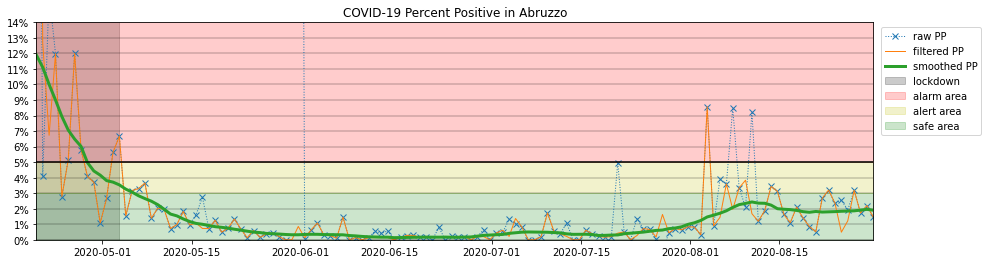

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.447777,1.447777,1.904881
2020-08-28 17:00:00,2.207506,2.207506,1.958452
2020-08-27 17:00:00,1.722488,1.722488,1.909504
2020-08-26 17:00:00,3.186275,3.186275,1.865124
2020-08-25 17:00:00,1.923077,1.221747,1.847720
2020-08-24 17:00:00,2.547771,0.490196,1.837366
2020-08-23 17:00:00,2.348993,2.348993,1.814391


***

# Basilicata

## Plot

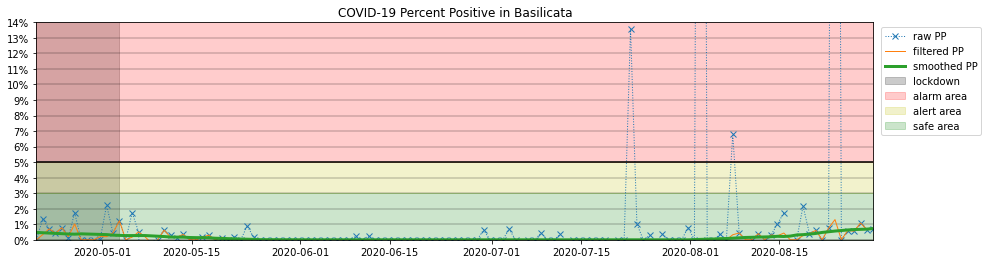

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,0.722543,0.722543,0.726440
2020-08-28 17:00:00,0.652529,0.652529,0.687110
2020-08-27 17:00:00,1.081081,1.081081,0.676045
2020-08-26 17:00:00,0.557621,0.557621,0.659524
2020-08-25 17:00:00,0.597610,0.597610,0.633713
2020-08-24 17:00:00,0.000000,0.000000,0.600555
2020-08-23 17:00:00,100.000000,1.302083,0.562653


***

# Calabria

## Plot

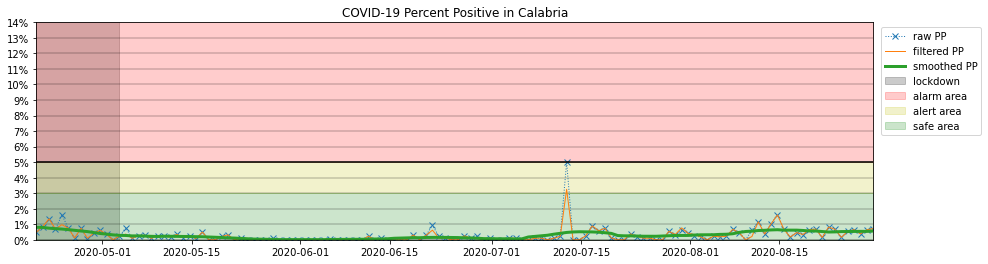

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,0.718954,0.718954,0.567305
2020-08-28 17:00:00,0.650195,0.650195,0.541450
2020-08-27 17:00:00,0.374065,0.374065,0.543653
2020-08-26 17:00:00,0.653595,0.653595,0.546119
2020-08-25 17:00:00,0.547196,0.547196,0.534842
2020-08-24 17:00:00,0.157480,0.157480,0.529869
2020-08-23 17:00:00,0.675676,0.675676,0.509440


***

# Campania

## Plot

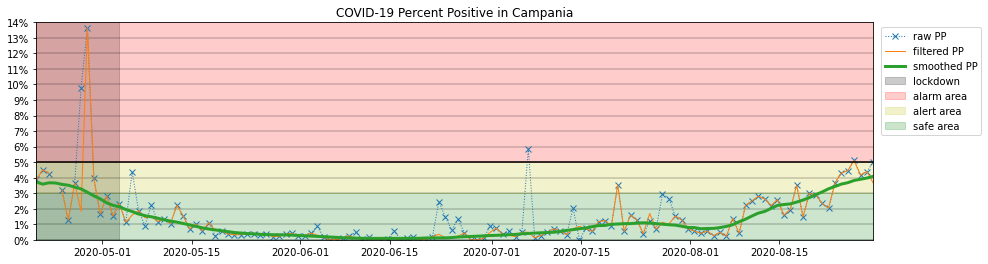

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,5.011997,3.639030,4.085698
2020-08-28 17:00:00,4.391649,4.391649,3.975582
2020-08-27 17:00:00,4.161332,4.161332,3.901100
2020-08-26 17:00:00,5.107832,5.107832,3.822095
2020-08-25 17:00:00,4.454487,4.454487,3.676760
2020-08-24 17:00:00,4.305865,4.305865,3.586716
2020-08-23 17:00:00,3.663393,3.663393,3.439133


***

# Emilia-Romagna

## Plot

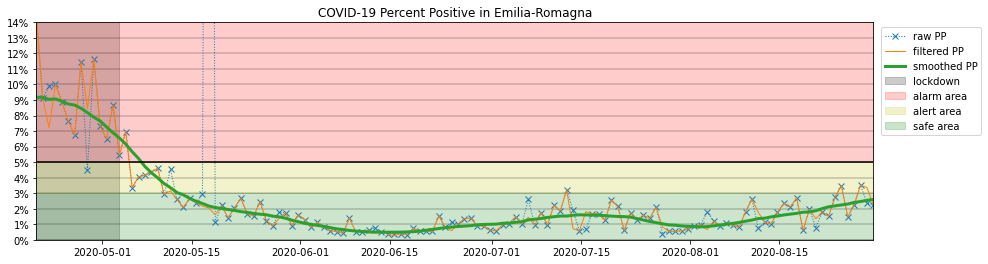

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,2.251776,2.251776,2.602135
2020-08-28 17:00:00,2.380952,3.367556,2.541476
2020-08-27 17:00:00,3.511294,3.511294,2.464559
2020-08-26 17:00:00,2.259461,2.259461,2.406994
2020-08-25 17:00:00,1.476602,1.476602,2.302692
2020-08-24 17:00:00,3.483483,3.483483,2.248156
2020-08-23 17:00:00,2.748918,2.748918,2.185454


***

# Friuli Venezia Giulia

## Plot

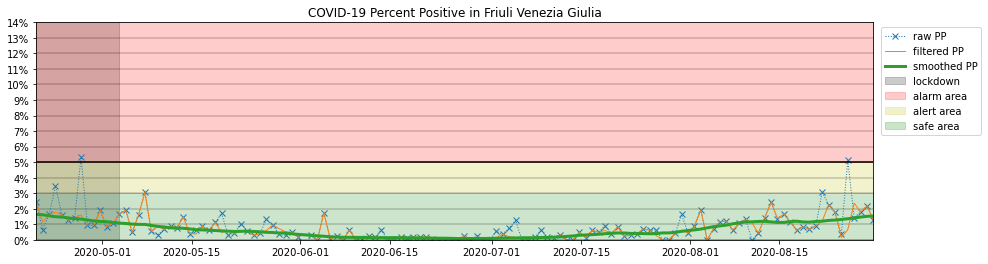

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.302083,1.302083,1.534325
2020-08-28 17:00:00,2.176403,2.176403,1.510125
2020-08-27 17:00:00,1.788269,1.788269,1.464074
2020-08-26 17:00:00,1.423027,2.360515,1.402552
2020-08-25 17:00:00,5.142857,0.654784,1.356457
2020-08-24 17:00:00,0.366972,0.148038,1.308534
2020-08-23 17:00:00,1.776462,1.776462,1.271962


***

# Lazio

## Plot

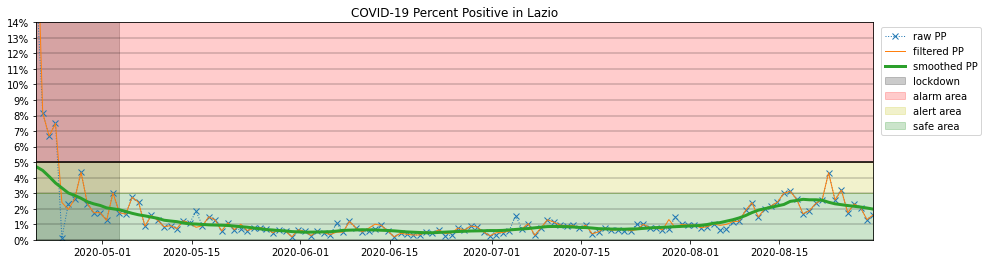

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.612143,1.612143,1.975926
2020-08-28 17:00:00,1.305647,1.305647,2.046913
2020-08-27 17:00:00,2.071691,2.071691,2.110049
2020-08-26 17:00:00,2.314947,2.314947,2.159483
2020-08-25 17:00:00,1.743902,1.743902,2.204789
2020-08-24 17:00:00,3.199649,3.199649,2.258810
2020-08-23 17:00:00,2.563745,2.563745,2.317476


***

# Liguria

## Plot

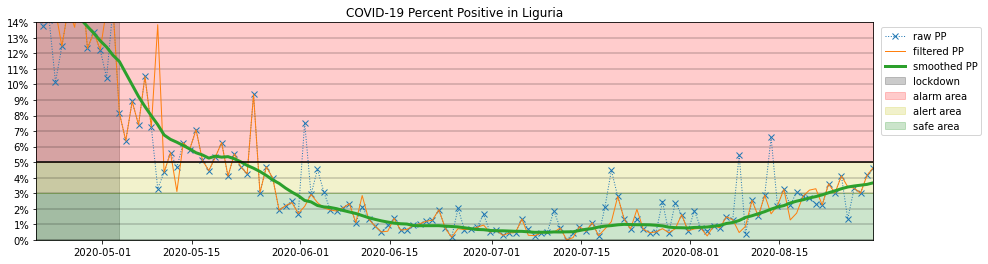

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,4.653465,4.653465,3.669742
2020-08-28 17:00:00,4.140414,4.140414,3.566888
2020-08-27 17:00:00,3.008130,3.008130,3.516578
2020-08-26 17:00:00,3.325223,3.325223,3.464932
2020-08-25 17:00:00,1.342282,3.411633,3.398430
2020-08-24 17:00:00,4.113924,4.113924,3.288357
2020-08-23 17:00:00,3.007519,3.007519,3.152289


***

# Lombardia

## Plot

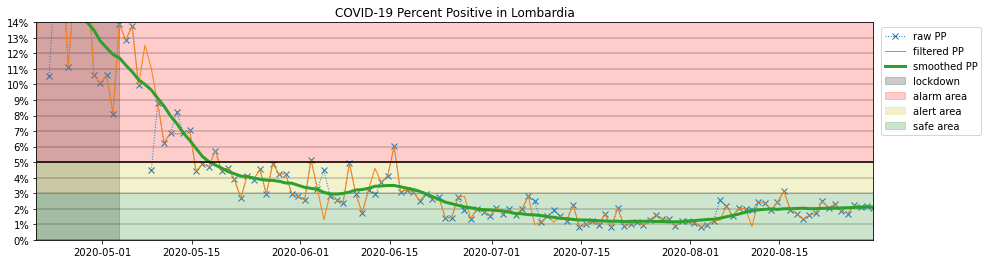

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,2.065466,2.065466,2.105053
2020-08-28 17:00:00,2.190945,2.190945,2.117834
2020-08-27 17:00:00,2.136082,2.136082,2.102949
2020-08-26 17:00:00,2.229590,2.229590,2.086257
2020-08-25 17:00:00,1.672993,1.672993,2.066687
2020-08-24 17:00:00,1.868524,1.868524,2.051478
2020-08-23 17:00:00,2.300732,2.300732,2.036079


***

# Marche

## Plot

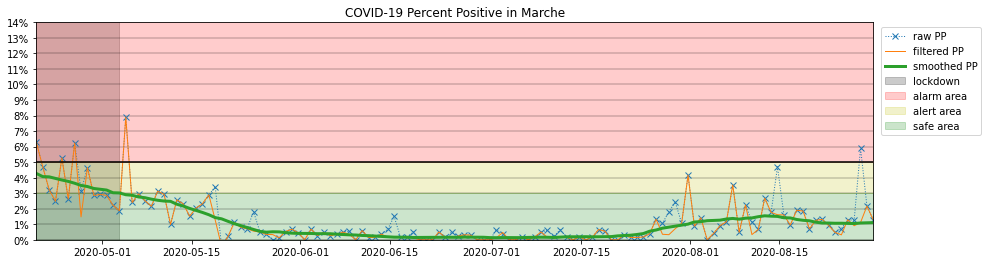

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.272534,1.272534,1.107018
2020-08-28 17:00:00,2.171137,2.171137,1.096082
2020-08-27 17:00:00,5.899420,1.112186,1.082756
2020-08-26 17:00:00,1.262272,0.903614,1.046868
2020-08-25 17:00:00,1.294118,1.294118,1.058711
2020-08-24 17:00:00,0.710900,0.318134,1.066931
2020-08-23 17:00:00,0.479846,0.479846,1.065185


***

# Molise

## Plot

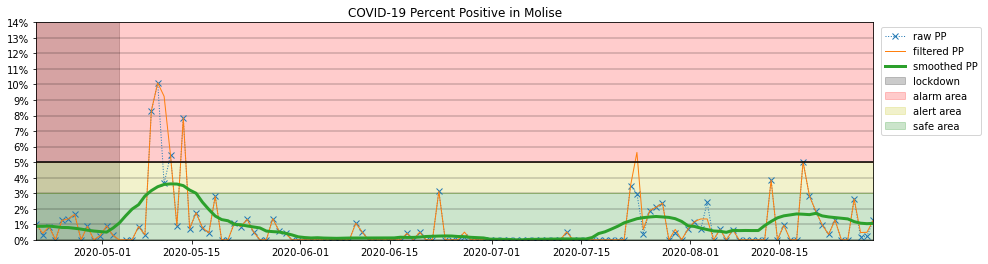

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.273885,1.273885,1.057002
2020-08-28 17:00:00,0.216450,0.480769,1.038272
2020-08-27 17:00:00,0.173913,0.469484,1.070071
2020-08-26 17:00:00,2.631579,2.631579,1.169961
2020-08-25 17:00:00,0.000000,0.000000,1.345406
2020-08-24 17:00:00,0.000000,0.000000,1.384334
2020-08-23 17:00:00,1.282051,1.282051,1.429311


***

# P.A. Bolzano

## Plot

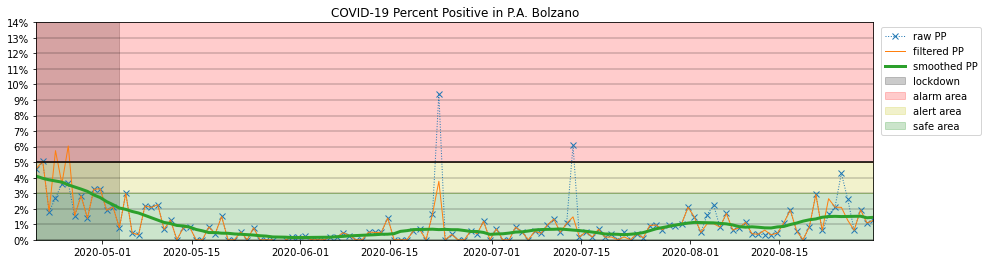

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.250000,1.250000,1.447621
2020-08-28 17:00:00,1.084011,1.084011,1.418142
2020-08-27 17:00:00,1.927195,1.927195,1.519598
2020-08-26 17:00:00,0.617284,0.617284,1.516202
2020-08-25 17:00:00,2.601156,1.251739,1.503992
2020-08-24 17:00:00,4.285714,2.089136,1.495824
2020-08-23 17:00:00,2.103560,2.103560,1.509935


***

# P.A. Trento

## Plot

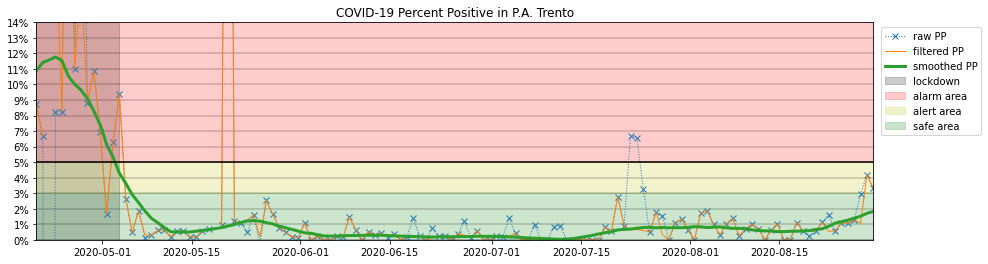

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,3.325416,3.325416,1.827497
2020-08-28 17:00:00,4.177546,4.177546,1.704650
2020-08-27 17:00:00,2.941176,1.078431,1.520745
2020-08-26 17:00:00,1.268116,1.268116,1.387257
2020-08-25 17:00:00,1.056338,1.056338,1.262149
2020-08-24 17:00:00,1.086957,1.086957,1.167194
2020-08-23 17:00:00,0.571429,0.571429,1.065724


***

# Piemonte

## Plot

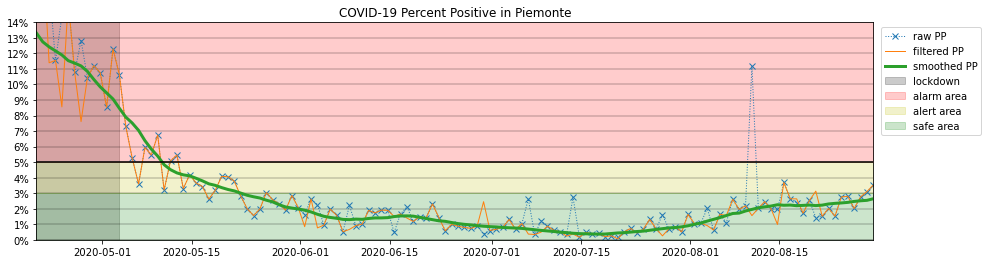

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,3.534957,3.534957,2.644000
2020-08-28 17:00:00,3.100511,3.100511,2.540976
2020-08-27 17:00:00,2.755166,2.755166,2.512414
2020-08-26 17:00:00,2.016671,2.016671,2.470223
2020-08-25 17:00:00,2.805118,2.805118,2.408638
2020-08-24 17:00:00,2.758621,2.758621,2.373866
2020-08-23 17:00:00,1.520087,1.520087,2.346647


***

# Puglia

## Plot

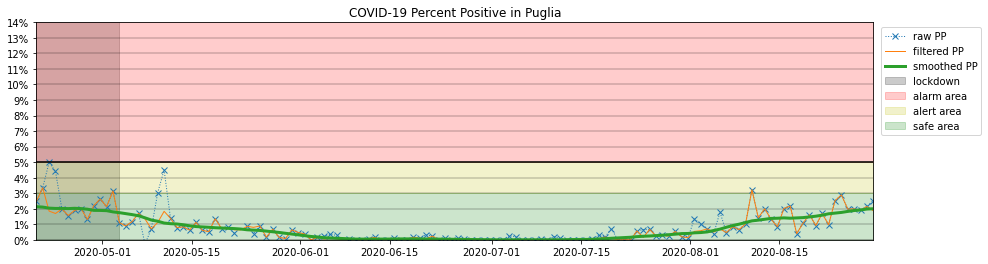

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,2.529183,1.867704,1.999416
2020-08-28 17:00:00,2.149178,2.149178,1.980500
2020-08-27 17:00:00,1.899757,1.899757,1.918608
2020-08-26 17:00:00,1.985981,1.985981,1.884611
2020-08-25 17:00:00,1.978199,1.978199,1.827487
2020-08-24 17:00:00,2.892031,2.892031,1.762213
2020-08-23 17:00:00,2.515244,2.515244,1.722024


***

# Sardegna

## Plot

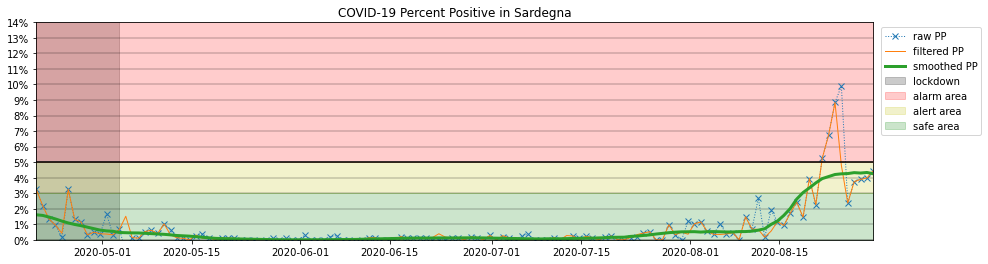

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,4.450095,4.450095,4.251694
2020-08-28 17:00:00,3.979740,3.979740,4.334004
2020-08-27 17:00:00,3.893443,3.893443,4.298662
2020-08-26 17:00:00,3.745583,3.745583,4.323896
2020-08-25 17:00:00,2.362752,2.362752,4.264307
2020-08-24 17:00:00,9.902067,4.787813,4.247306
2020-08-23 17:00:00,8.842795,8.842795,4.204226


***

# Sicilia

## Plot

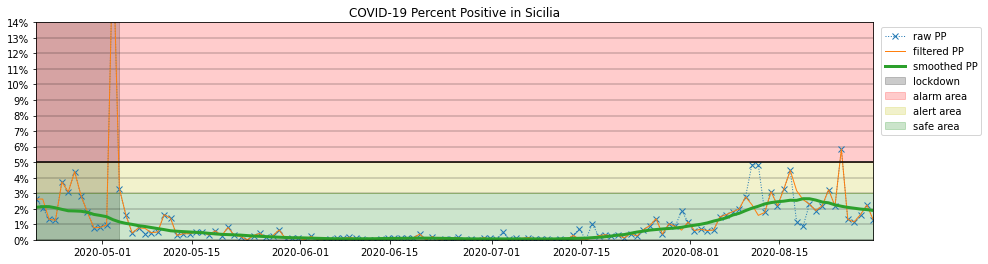

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.268037,1.268037,1.888994
2020-08-28 17:00:00,2.240664,2.240664,1.941478
2020-08-27 17:00:00,1.626545,1.626545,1.978153
2020-08-26 17:00:00,1.149425,1.149425,2.030700
2020-08-25 17:00:00,1.312910,1.312910,2.089129
2020-08-24 17:00:00,5.850585,5.850585,2.159772
2020-08-23 17:00:00,2.169870,2.169870,2.250413


***

# Toscana

## Plot

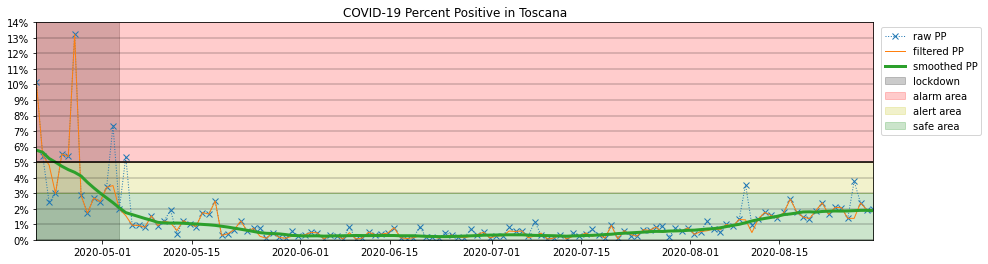

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.955782,1.955782,1.875853
2020-08-28 17:00:00,1.920825,1.920825,1.896922
2020-08-27 17:00:00,2.375240,2.375240,1.894902
2020-08-26 17:00:00,3.766963,1.380440,1.873115
2020-08-25 17:00:00,1.382676,1.382676,1.857002
2020-08-24 17:00:00,2.075472,2.075472,1.849029
2020-08-23 17:00:00,2.084069,2.084069,1.854938


***

# Umbria

## Plot

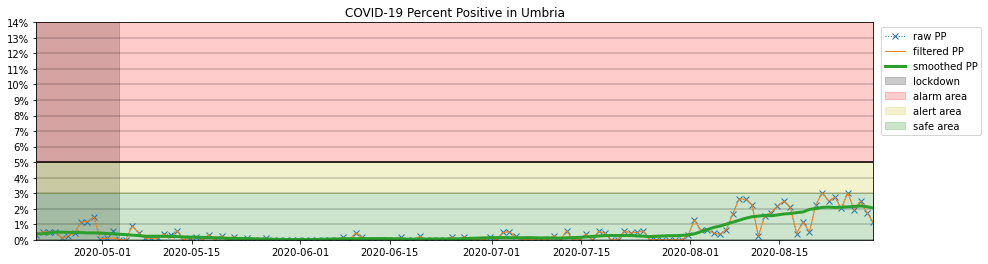

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,1.123596,1.123596,2.048458
2020-08-28 17:00:00,1.743265,1.743265,2.131027
2020-08-27 17:00:00,2.509410,2.509410,2.179254
2020-08-26 17:00:00,1.924928,1.924928,2.145462
2020-08-25 17:00:00,3.033473,3.033473,2.118628
2020-08-24 17:00:00,2.022059,2.022059,2.095636
2020-08-23 17:00:00,2.733813,2.733813,2.079290


***

# Valle d'Aosta

## Plot

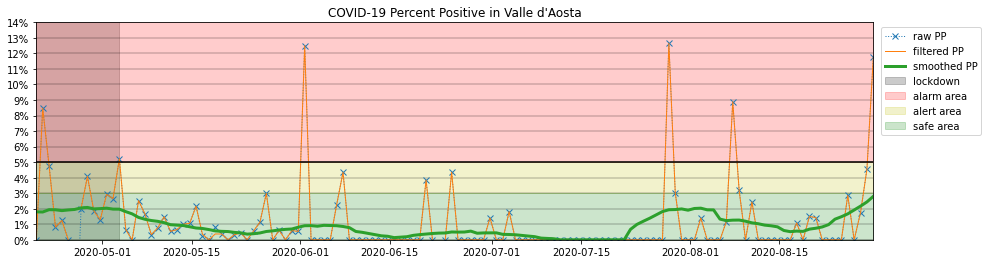

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,11.764706,11.764706,2.797468
2020-08-28 17:00:00,4.545455,4.545455,2.438780
2020-08-27 17:00:00,1.754386,1.754386,2.167869
2020-08-26 17:00:00,0.000000,0.000000,1.915661
2020-08-25 17:00:00,2.857143,2.857143,1.669904
2020-08-24 17:00:00,0.000000,0.000000,1.485562
2020-08-23 17:00:00,0.000000,0.000000,1.327517


***

# Veneto

## Plot

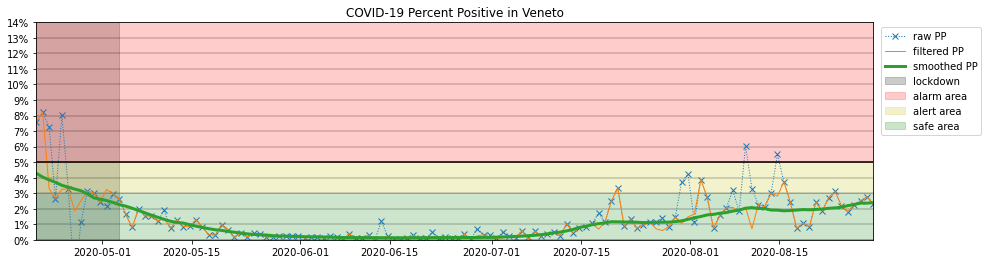

## Last week

,raw PP,filtered PP,smoothed PP
date,,,
2020-08-29 17:00:00,2.298676,2.298676,2.393781
2020-08-28 17:00:00,2.777206,2.777206,2.361548
2020-08-27 17:00:00,2.502844,2.502844,2.362330
2020-08-26 17:00:00,2.266071,2.266071,2.272102
2020-08-25 17:00:00,1.806589,1.806589,2.198700
2020-08-24 17:00:00,2.203229,2.203229,2.099475
2020-08-23 17:00:00,3.135813,3.135813,2.053771


***

In [9]:
latest = {
    "region": [],
    "raw PP": [],
    "filtered PP": [],
    "smoothed PP": []
}

for region in countries:
    display(Markdown(f"# {region}"))
    ok = ko.loc[region]
    
    n_sigmas_pos = 2.0
    n_sigmas_tst = 2.0
    #if region == ["Valle d'Aosta"]:
    #    n_sigmas_pos = 5.0
    if region in ["Basilicata", "Molise"]:
        n_sigmas_tst = 1.5
    if ok['nuovi_positivi'][1:].max() > 30:
        pos, pos_outs = hampel_filter_pandas(ok['nuovi_positivi'][1:], 7, n_sigmas=n_sigmas_pos)
        rig = f"(outliers rigettati con Hampel filter, $\sigma={n_sigmas_pos}$)"
    else:
        pos = ok['nuovi_positivi'][1:]
        rig = "(outliers non rigettati)"
    tst, tst_outs = hampel_filter_pandas(ok['casi_testati'].diff()[1:], 7, n_sigmas=n_sigmas_tst)
    tst[tst<=0] = np.nan
    
    pos_sm = pos.rolling(14,
                    win_type='gaussian',
                    min_periods=1,
                    center=True).mean(std=5).values
    tst_sm = tst.rolling(14,
                    win_type='gaussian',
                    min_periods=1,
                    center=True).mean(std=5).values
    
    indice = ok['nuovi_positivi'][1:] / ok['casi_testati'].diff()[1:] * 100
    filtered = pos / tst * 100
    smooth = pos_sm / tst_sm * 100

    latest["region"].append(region)
    latest["raw PP"].append(indice[-1])
    latest["filtered PP"].append(filtered[-1])
    latest["smoothed PP"].append(smooth[-1])
    
    display(Markdown(f"## Plot"))
    fig, ax = plt.subplots(figsize=(15, 4))

    ax.plot(indice, 'x:', label="raw PP", lw=1)
    ax.plot(filtered, label="filtered PP", lw=1)
    ax.plot(indice.index, smooth, lw=3, label="smoothed PP")
    
    #ax.plot(indice, 'ok:', label="observed", lw=1, ms=3)
    #ax.plot(indice.index, smooth, lw=3, label="smoothed")

    ax.axhline(0, c="k", alpha=.2)
    ax.hlines(np.arange(0,15,1), indice.index[0], indice.index[-1], color="k", alpha=.2)

    ax.axhline(5, c="k")

    ax.fill_betweenx(
        [0,20],
        indice.index[indice.index>=pd.to_datetime("2020-03-11")][0],
        indice.index[indice.index<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )

    ax.fill_between(indice.index, 5, 20, color="r", alpha=.2, label="alarm area")
    ax.fill_between(indice.index, 3, 5, color="y", alpha=.2, label="alert area")
    ax.fill_between(indice.index, 0, 3, color="g", alpha=.2, label="safe area")


    ax.set_yticks(np.arange(0,15,1))
    ax.set_yticklabels([f"{p:.0%}" for p in np.arange(0,.15,.01)])
    ax.set_ylim(0, 14)
    ax.set_xlim(indice.index[0], indice.index[-1])
    ax.legend(loc="upper right", bbox_to_anchor=(1.135,1))
    ax.set_title(f"COVID-19 Percent Positive in {region}")
    plt.show()
    plt.close(fig="all")
    
    display(Markdown(f"## Last week"))
    idf = pd.DataFrame({
        "date":indice.index[-7:],
        "raw PP":indice.values[-7:],
        "filtered PP":filtered.values[-7:],
        "smoothed PP":smooth[-7:]
    })
    idf.set_index('date', inplace=True)
    display(HTML(idf[::-1].to_html()))
    display(Markdown("***"))

# SUMMARY

In [10]:
ldf = pd.DataFrame(latest)
ldf.set_index('region', inplace=True)

In [11]:
display(HTML(ldf.to_html()))

,raw PP,filtered PP,smoothed PP
region,,,
Abruzzo,1.447777,1.447777,1.904881
Basilicata,0.722543,0.722543,0.726440
Calabria,0.718954,0.718954,0.567305
Campania,5.011997,3.639030,4.085698
Emilia-Romagna,2.251776,2.251776,2.602135
Friuli Venezia Giulia,1.302083,1.302083,1.534325
Lazio,1.612143,1.612143,1.975926
Liguria,4.653465,4.653465,3.669742
Lombardia,2.065466,2.065466,2.105053


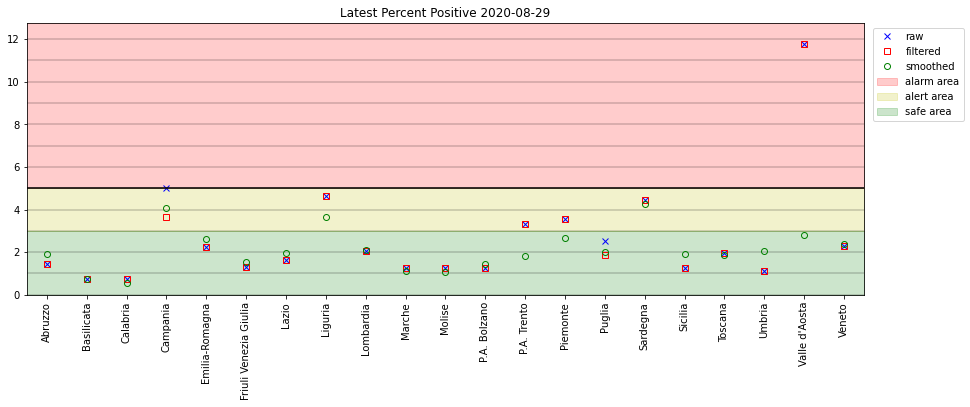

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

ymax = max(ldf['raw PP'].max(), ldf['filtered PP'].max(), ldf['smoothed PP'].max())+1

ax.plot(ldf.index, ldf['raw PP'], 'xb', lw=0, label="raw")
ax.plot(ldf.index, ldf['filtered PP'], 'sr', lw=0, label="filtered", markeredgecolor="r", markerfacecolor='none')
ax.plot(ldf.index, ldf['smoothed PP'], 'og', lw=0, label="smoothed", markeredgecolor="g", markerfacecolor='none')

ax.set_xticks(np.arange(countries.size))
ax.set_xticklabels(countries.values, rotation=90)

ax.hlines(np.arange(0,ymax,1), -1, countries.size+1, color="k", alpha=.2)

ax.axhline(5, c="k")

ax.fill_between([-1, countries.size+1], 5, ymax, color="r", alpha=.2, label="alarm area")
ax.fill_between([-1, countries.size+1], 3, 5, color="y", alpha=.2, label="alert area")
ax.fill_between([-1, countries.size+1], 0, 3, color="g", alpha=.2, label="safe area")

ax.set_xlim(-.5, countries.size-.5)
ax.set_ylim(0, ymax)

ax.legend(loc="upper right", bbox_to_anchor=(1.125,1))

ax.set_title(f"Latest Percent Positive {days[-1].date()}")
plt.show();

In [13]:
_ = """indice = ok['totale_casi'][1:]*100 / ok['casi_testati'][1:]
smooth = indice.rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).values

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(indice, 'ok:', label="observed", lw=1, ms=3)
ax.plot(indice.index, smooth, lw=3, label="smoothed")

ax.axhline(0, c="k", alpha=.2)
ax.hlines(np.arange(0,15,1), indice.index[0], indice.index[-1], color="k", alpha=.2)

ax.axhline(5, c="k")

ax.fill_betweenx(
    [0,20],
    indice.index[indice.index>=pd.to_datetime("2020-03-11")][0],
    indice.index[indice.index<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)

ax.fill_between(indice.index, 5, 20, color="r", alpha=.2, label="alarm area")
ax.fill_between(indice.index, 3, 5, color="y", alpha=.2, label="alert area")
ax.fill_between(indice.index, 0, 3, color="g", alpha=.2, label="safe area")


ax.set_yticks(np.arange(0,15,1))
ax.set_yticklabels([f"{p:.0%}" for p in np.arange(0,.15,.01)])
ax.set_ylim(0, 30)
ax.set_xlim(indice.index[0], indice.index[-1])
ax.legend(loc="upper right", bbox_to_anchor=(1.125,1))
ax.set_title("COVID-19 Percent Positive in Italy")
plt.plot();"""